
# **1/ *Business* Understanding**


BO1 : Prédire les coûts médicaux afin d’anticiper les dépenses.                  //"Prédire le coût médical des assurés pour optimiser la tarification, réduire les risques et automatiser le processus."
                                
DSO1: Modèle de régression pour prédire les coûts médicaux (charges).//"Construire un modèle de regression prédictive avec une MAE < 3 000 $ pour estimer les charges médicales à partir des données clients."


BO2:
Les assureurs veulent identifier les assurés « atypiques », c’est-à-dire ceux dont les profils ou comportements diffèrent fortement de la majorité.

DSO2: Détection d’anomalies globales

Objectif : identifier automatiquement les assurés dont les caractéristiques globales (numériques + catégorielles) diffèrent significativement de la majorité.

Méthodes envisagées :

IsolationForest (robuste et scalable).

OneClassSVM (frontière d’inliers/outliers).

# **2/ *Data* Understanding**

* data description
* data exploration
* data selection
* data visualization (ACP/ACM)

This cell imports the main Python libraries used throughout the notebook:

NumPy for numerical operations

Pandas for data manipulation and analysis

Matplotlib for plotting and visualization It then loads the dataset dataAssurance.csv into a Pandas DataFrame named data.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
data=pd.read_csv("dataAssurance.csv")

we are defining a function If the DataFrame has more than 500 rows, it only shows the first limit rows (default: 20). This prevents overwhelming outputs for large datasets.

In [ ]:
def show_table(title: str, frame: pd.DataFrame, head_only_if_big=True, limit=20):
    print(f"\n=== {title} ===")
    if head_only_if_big and len(frame) > 500:
        display(frame.head(limit))
        print(f"... ({len(frame)} rows total)")
    else:
        display(frame)

Here, a function iqr_outlier_count is defined to detect outliers using the Interquartile Range (IQR) method.

In [ ]:
def iqr_outlier_count(series: pd.Series) -> int:
    s = series.dropna()
    if s.empty:
        return 0
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return int(((series < lower) | (series > upper)).sum())

data → displays the full dataset.

In [ ]:
data

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1438,35.0,female,27.700,3.0,no,southwest,6414.17800
1439,36.0,female,26.885,0.0,no,northwest,5267.81815
1440,60.0,female,38.060,0.0,no,southeast,12648.70340
1441,20.0,male,NaN,1.0,no,southeast,27724.28875


info() → gives structure: number of entries, columns, and memory usage.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1406 non-null   float64
 1   sex       1405 non-null   object 
 2   bmi       1410 non-null   float64
 3   children  1414 non-null   float64
 4   smoker    1417 non-null   object 
 5   region    1410 non-null   object 
 6   charges   1414 non-null   float64
dtypes: float64(4), object(3)
memory usage: 79.0+ KB


describe() → computes descriptive statistics (mean, std, min, quartiles, max).

In [ ]:
data.describe()

,age,bmi,children,charges
count,1406.000000,1410.000000,1414.000000,1414.000000
mean,39.179232,30.637681,1.086280,13179.307173
std,14.067120,6.112450,1.196088,11987.371506
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4748.057175
50%,39.000000,30.302500,1.000000,9369.615750
75%,51.000000,34.656250,2.000000,16547.261588
max,64.000000,53.130000,5.000000,63770.428010


dtypes → lists column data types.

In [ ]:
data.dtypes

,0
age,float64
sex,object
bmi,float64
children,float64
smoker,object
region,object
charges,float64


isna().sum() → counts missing values per column.

In [ ]:
data.isna().sum()

,0
age,37
sex,38
bmi,33
children,29
smoker,26
region,33
charges,29


most of our Nan values are either equal 2% or less This cell calculates the number of unique values in each column, including NaN. It stores the result in a new DataFrame unique_df

In [ ]:
unique_counts = data.nunique(dropna=False)
unique_df = (
    pd.DataFrame({"unique_count_including_NaN": unique_counts})
    .rename_axis("column")
    .reset_index()
    .sort_values("unique_count_including_NaN", ascending=False)
)
show_table("04 - Unique counts per column", unique_df, head_only_if_big=False)


=== 04 - Unique counts per column ===


,column,unique_count_including_NaN
6,charges,1310
2,bmi,544
0,age,48
3,children,7
5,region,5
1,sex,3
4,smoker,3


# **Identify numeric columns & summarize**
What this does

Selects numeric features with select_dtypes.
Builds a quick per-column summary (count, missing, unique).
Prepares lists used later for plots, correlations, and outlier checks.

ACP/ACM

In [ ]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_summary = data[num_cols].describe().T
num_summary["skew"] = data[num_cols].skew(numeric_only=True)
num_summary["kurtosis"] = data[num_cols].kurtosis(numeric_only=True)
show_table("05 - Numerical summary (with skew/kurtosis)",
           num_summary.round(4).rename_axis("column").reset_index(), head_only_if_big=False)


=== 05 - Numerical summary (with skew/kurtosis) ===


,column,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,age,1406.0,39.1792,14.0671,18.0000,26.0000,39.0000,51.0000,64.000,0.0645,-1.2416
1,bmi,1410.0,30.6377,6.1125,15.9600,26.2200,30.3025,34.6562,53.130,0.3081,-0.0059
2,children,1414.0,1.0863,1.1961,0.0000,0.0000,1.0000,2.0000,5.000,0.9418,0.2206
3,charges,1414.0,13179.3072,11987.3715,1121.8739,4748.0572,9369.6158,16547.2616,63770.428,1.5364,1.7230


SKew determines the symetry of our data and Kurtosis show us which data has outliers so we can work on them :D

###  Identify categorical columns & value counts

**What this does**

- Collects **categorical features** (object/category dtypes).
- Computes **value counts** (including NaN) to gauge class balance and rare categories.

In [ ]:
cat_cols = data.select_dtypes(include=["object", "category"]).columns.tolist()
for c in cat_cols:
    vc  = data[c].value_counts(dropna=False, normalize=False)
    vcp = (data[c].value_counts(dropna=False, normalize=True) * 100).round(4)
    cat_value_counts = pd.DataFrame({"count": vc, "percentage_%": vcp}).rename_axis(c).reset_index()
    show_table(f"06 - Value counts for '{c}' (incl. NaN)", cat_value_counts)


=== 06 - Value counts for 'sex' (incl. NaN) ===


,sex,count,percentage_%
0,male,719,49.8267
1,female,686,47.5398
2,NaN,38,2.6334



=== 06 - Value counts for 'smoker' (incl. NaN) ===


,smoker,count,percentage_%
0,no,1132,78.4477
1,yes,285,19.7505
2,NaN,26,1.8018



=== 06 - Value counts for 'region' (incl. NaN) ===


,region,count,percentage_%
0,southeast,381,26.4033
1,northwest,345,23.9085
2,southwest,344,23.8392
3,northeast,340,23.5620
4,NaN,33,2.2869


### Duplicate rows: count & preview


- Counts **duplicate rows** and shows a sample of them.
- Helps decide whether to **drop duplicates** as part of cleaning.

In [ ]:
dupes = int(data.duplicated().sum())
show_table("07 - Duplicate row count", pd.DataFrame({"duplicate_rows":[dupes]}), head_only_if_big=False)


=== 07 - Duplicate row count ===


,duplicate_rows
0,105


**What this does**

- Performs a step in the EDA/cleaning/modelling workflow.
- Outputs intermediate artifacts for verification (tables or plots).

In [ ]:
duplicates_df = data[data.duplicated(keep=False)]

show_table("07 - Duplicate rows", duplicates_df, head_only_if_big=False)


=== 07 - Duplicate rows ===


,age,sex,bmi,children,smoker,region,charges
9,60.0,female,25.840,0.0,no,northwest,28923.13692
23,34.0,female,31.920,1.0,yes,northeast,37701.87680
24,37.0,male,28.025,2.0,no,northwest,6203.90175
30,22.0,male,35.600,0.0,yes,southwest,35585.57600
44,NaN,male,37.050,1.0,no,northeast,6079.67150
...,...,...,...,...,...,...,...
1438,35.0,female,27.700,3.0,no,southwest,6414.17800
1439,36.0,female,26.885,0.0,no,northwest,5267.81815
1440,60.0,female,38.060,0.0,no,southeast,12648.70340
1441,20.0,male,NaN,1.0,no,southeast,27724.28875


we need to remove the duplicated data to ensure the consistency of the model

### Outlier detection (IQR method)

- Uses **IQR (Interquartile Range)** to count outliers per numeric column.
- Outliers fall outside `[Q1−1.5×IQR, Q3+1.5×IQR]`.

In [ ]:
outliers = {c: iqr_outlier_count(data[c]) for c in num_cols}
outliers_df = pd.DataFrame(list(outliers.items()), columns=["column", "iqr_outlier_count"])\
                .sort_values("iqr_outlier_count", ascending=False)
show_table("08 - IQR outlier counts (numeric columns)", outliers_df, head_only_if_big=False)


=== 08 - IQR outlier counts (numeric columns) ===


,column,iqr_outlier_count
3,charges,145
1,bmi,10
0,age,0
2,children,0


- Computes pairwise **Pearson correlations** among numeric features.
- Useful to spot **multicollinearity** and relationships with the target (if numeric).

In [ ]:
if len(num_cols) >= 2:
    corr_df = data[num_cols].corr().round(3)
    show_table("09 - Correlation matrix (numeric)", corr_df)


=== 09 - Correlation matrix (numeric) ===


,age,bmi,children,charges
age,1.000,0.113,0.034,0.302
bmi,0.113,1.000,0.001,0.200
children,0.034,0.001,1.000,0.051
charges,0.302,0.200,0.051,1.000


### this is a function that :

- Performs a step in the EDA/cleaning/modelling workflow.
- Outputs intermediate artifacts for verification (tables or plots).

In [ ]:
def show_table(title: str, frame: pd.DataFrame, head_only_if_big=True, limit=20):
    print(f"\n=== {title} ===")
    if head_only_if_big and len(frame) > 500:
        display(frame.head(limit))
        print(f"... ({len(frame)} rows total)")
    else:
        display(frame)

now we wat to show our data in diagrammes and frames



### Distributions of numeric features (histograms)

- Plots **histograms** for each numeric column to visualize distribution shape.
- Helps identify **skew**, **outliers**, and candidate transforms.

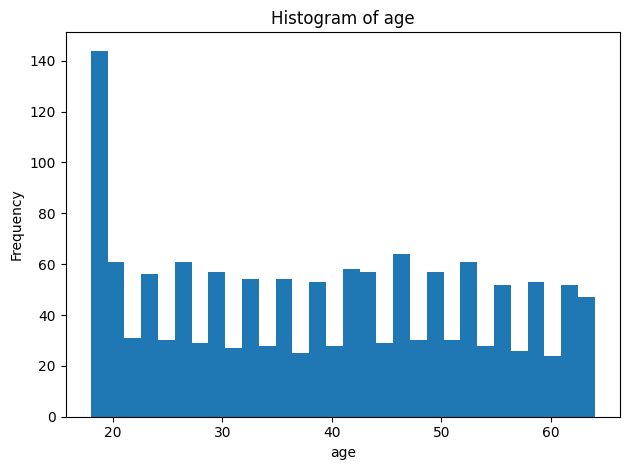

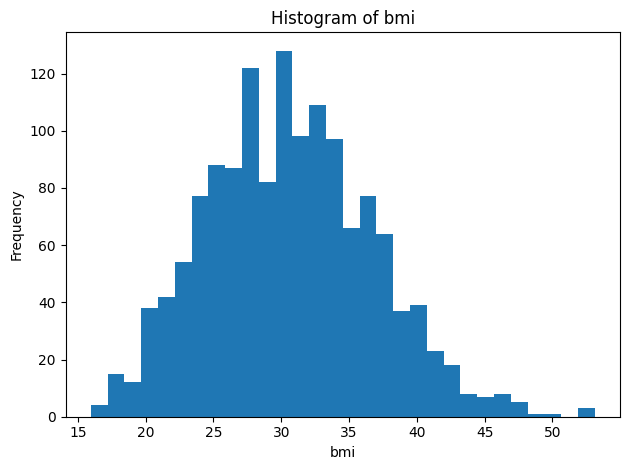

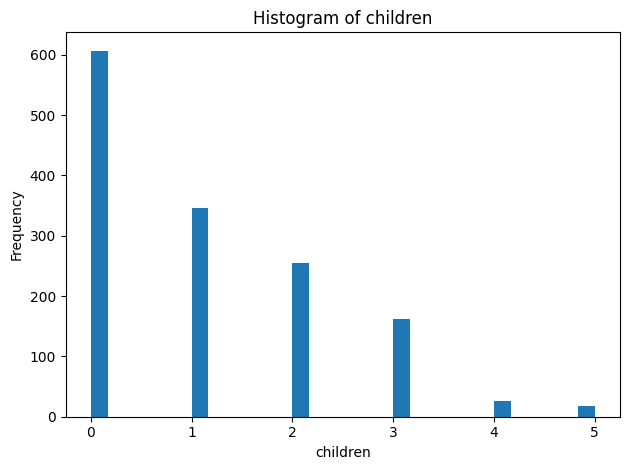

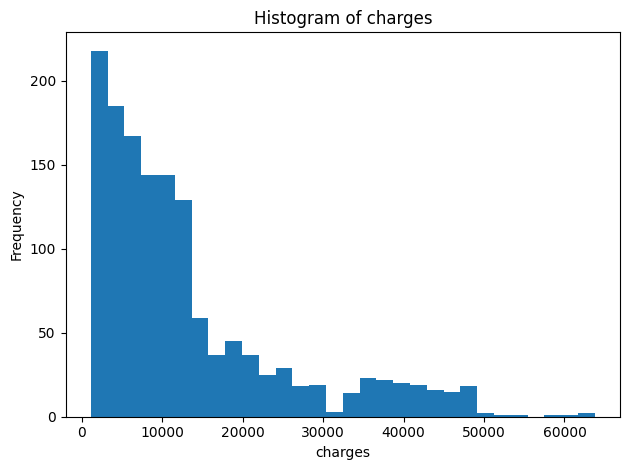

In [ ]:
for col in num_cols:
    plt.figure()
    plt.hist(data[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

### : Boxplots of numeric features

/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


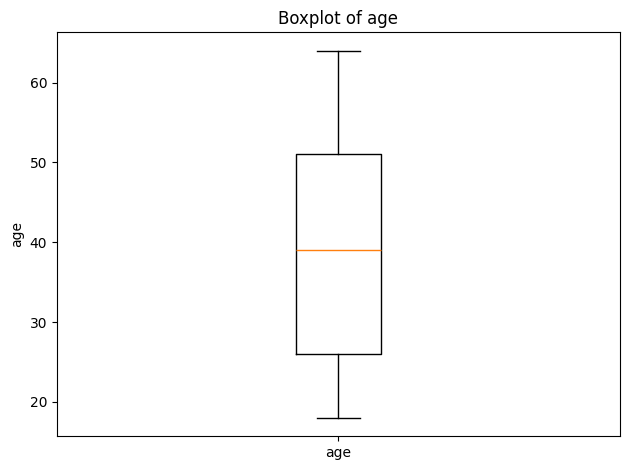

/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


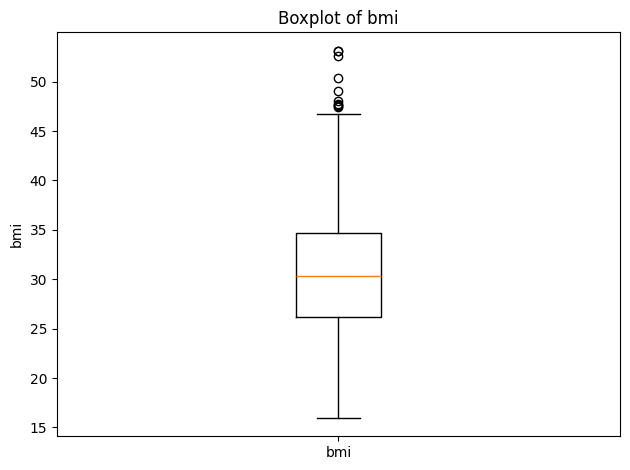

/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


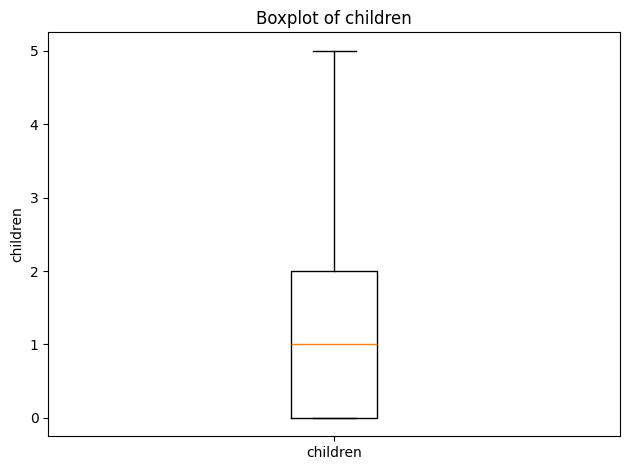

/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


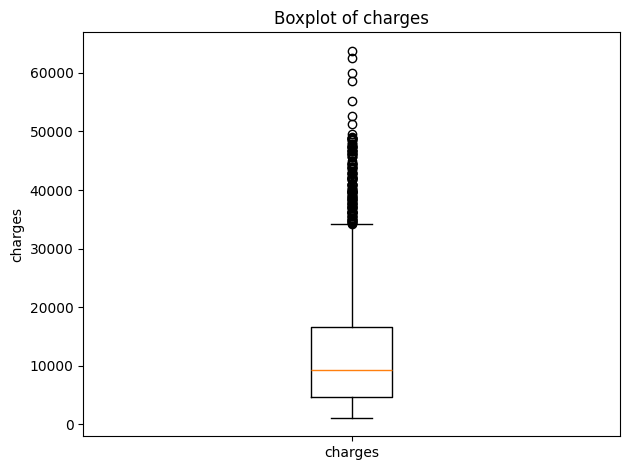

In [ ]:
for col in num_cols:
    plt.figure()
    plt.boxplot(data[col].dropna(), vert=True, labels=[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

- Performs a step in the EDA/cleaning/modelling workflow.
- Outputs intermediate artifacts for verification (tables or plots).

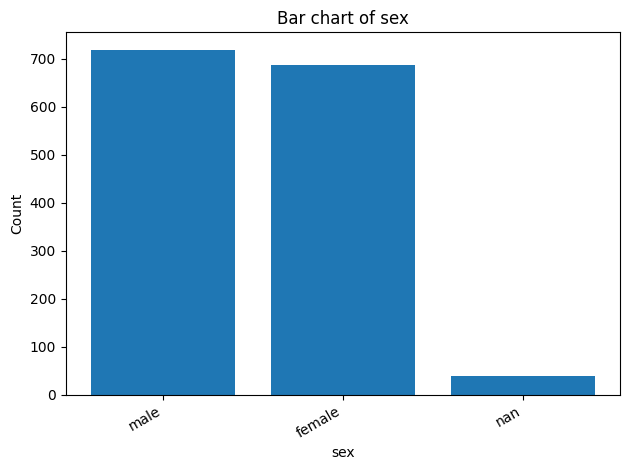

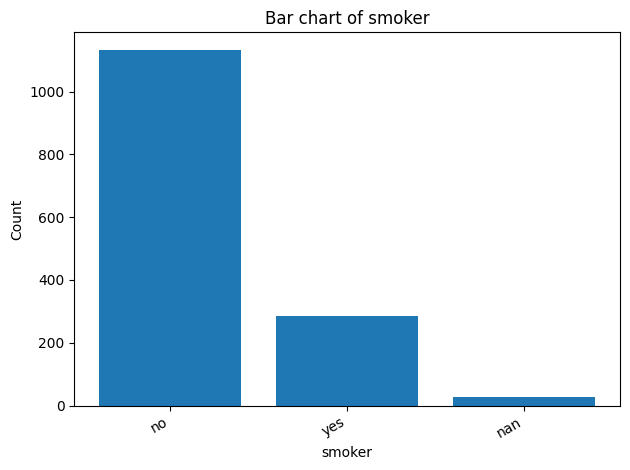

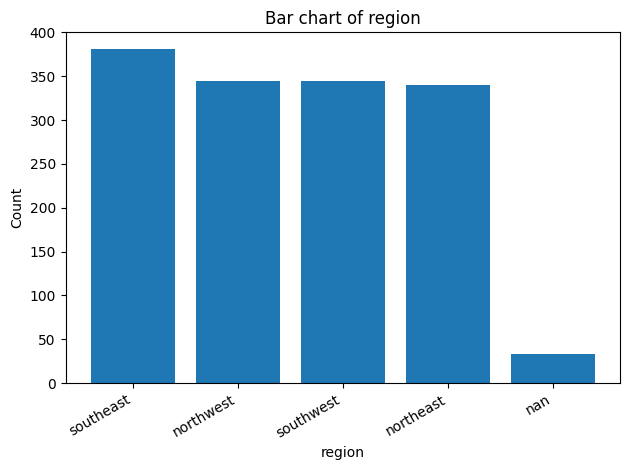

In [ ]:
for col in cat_cols:
    plt.figure()
    counts = data[col].value_counts(dropna=False)
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Bar chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

### Feature vs Charges: scatter

- Visualizes relationship between a feature (e.g., BMI) and **charges**.
- Useful to sense **trend**, **heteroscedasticity**, or non-linear patterns.

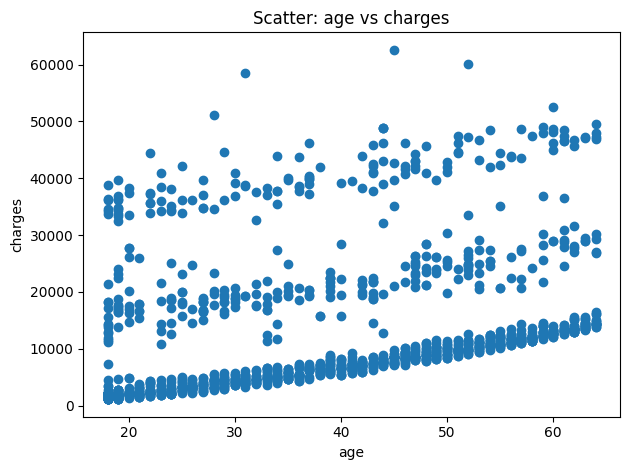

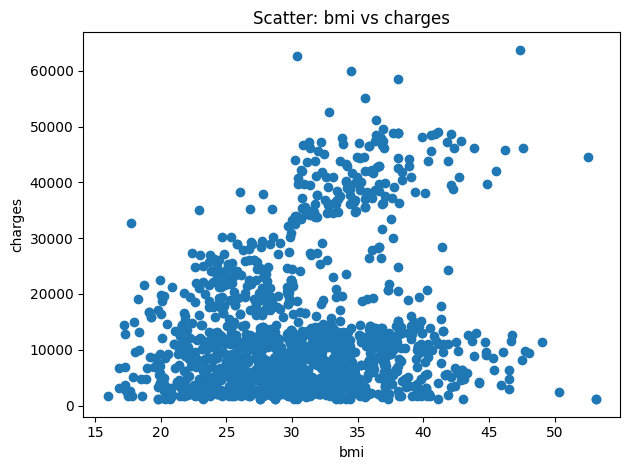

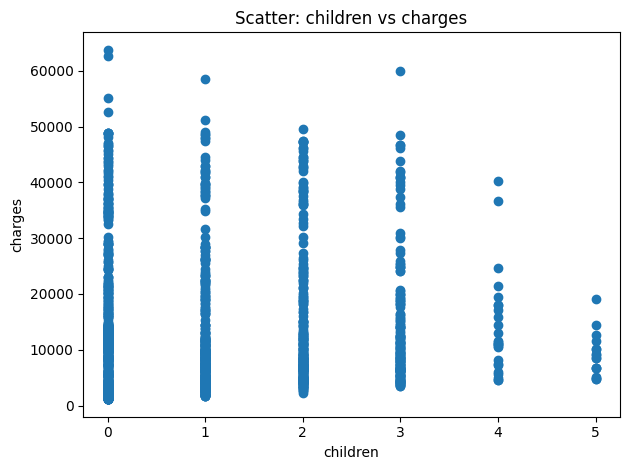

In [ ]:
if "charges" in num_cols:
    for col in [c for c in num_cols if c != "charges"]:
        plt.figure()
        plt.scatter(data[col], data["charges"])
        plt.title(f"Scatter: {col} vs charges")
        plt.xlabel(col)
        plt.ylabel("charges")
        plt.tight_layout()
        plt.show()

In [ ]:
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Rows: 1443, Columns: 7
Numeric columns: ['age', 'bmi', 'children', 'charges']
Categorical columns: ['sex', 'smoker', 'region']


- Selects **numeric features** with `select_dtypes`.
- Builds a quick **per-column summary** (count, missing, unique).
- Prepares lists used later for plots, correlations, and outlier checks.
- Counts **duplicate rows** and shows a sample of them.
- Helps decide whether to **drop duplicates** as part of cleaning.
- Uses **IQR (Interquartile Range)** to count outliers per numeric column.
- Outliers fall outside `[Q1−1.5×IQR, Q3+1.5×IQR]`.
- Computes pairwise **Pearson correlations** among numeric features.
- Useful to spot **multicollinearity** and relationships with the target (if numeric).
- Applies **One‑Hot Encoding** for nominal variables to make them usable by models.
- Drops the first dummy to avoid the **dummy variable trap**.
- Computes missing‑value **percentages** for numeric & categorical columns.
- Guides imputation strategy and feature removal decisions.


In [ ]:
missing_percentage_num = data.select_dtypes(include=[np.number]).isna().mean().mean()
missing_percentage_cat = data.select_dtypes(include=['object']).isna().mean().mean()
duplicates_percentage = data.duplicated().mean()
variances = data.select_dtypes(include=[np.number]).var()
low_variance_columns = variances[variances < 0.01].count()
outlier_threshold = 0.1  # <10% it is considered bad
outliers_percentage = (data.select_dtypes(include=[np.number])
                       .apply(lambda x: ((x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) |
                                         (x > (x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))))).mean()))
outlier_impact = (outliers_percentage > outlier_threshold).sum()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
encoded_data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)  # no dummy variable trap
corr_matrix = encoded_data.corr().abs()  # Use absolute correlation values
high_corr = (corr_matrix > 0.9).sum().sum() - len(corr_matrix)  # excluding self-correlation age with age for example
missing_score = 1 - missing_percentage_num
duplicates_score = 1 - duplicates_percentage
variance_score = 1 - (low_variance_columns / len(variances))  # lower variance = worse score
outlier_score = 1 - (outlier_impact / len(data.select_dtypes(include=[np.number])))  # More outliers = worse score
correlation_score = 1 - (high_corr / len(corr_matrix))  # More high correlations = worse score
data_quality_score = np.mean([missing_score, duplicates_score, variance_score, outlier_score, correlation_score])
print(f"\n=== Data Quality Score ===")
print(f"Data Quality Score: {data_quality_score:.4f}")
print("\n--- Breakdown of Data Quality Components ---")
print(f"Missing Data Score: {missing_score:.4f}")
print(f"Duplicates Score: {duplicates_score:.4f}")
print(f"Low Variance Feature Score: {variance_score:.4f}")
print(f"Outlier Impact Score: {outlier_score:.4f}")
print(f"Correlation Impact Score: {correlation_score:.4f}")



=== Data Quality Score ===
Data Quality Score: 0.9809

--- Breakdown of Data Quality Components ---
Missing Data Score: 0.9778
Duplicates Score: 0.9272
Low Variance Feature Score: 1.0000
Outlier Impact Score: 0.9993
Correlation Impact Score: 1.0000


We can assume our data is decent and using it we can arrive to some solid results

# **3/ *Data* Preparation**

1* nettoyage des donnees : verification des valeurs manquantes , detection des outliers , suppression , traitement outliers .                            
2* transformation des donnes .                                                  
3* features engineering .

### Datatype audit

- Prints **dtypes** after transformations to confirm expected numeric/categorical types.

In [ ]:
data.dtypes

,0
age,float64
sex,object
bmi,float64
children,float64
smoker,object
region,object
charges,float64


let's drop duplicates first

In [ ]:
data=data.drop_duplicates()

NAN treatement

for the qualitative features we opted to use mode to keep the dominant categorie as dominant

In [ ]:
cat_features = ['sex','smoker','region']
for col in cat_features:
    data[col].fillna(data[col].mode()[0], inplace=True)

/tmp/ipython-input-2472138509.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
/tmp/ipython-input-2472138509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].fillna(data[col].mode()[0], inplace=True)


In [ ]:
data.isna().sum()

,0
age,34
sex,0
bmi,31
children,27
smoker,0
region,0
charges,28


Numerical columns: Imputed with the median (we showed that data is skewed)

### Post‑imputation null check

- Selects **numeric features** with `select_dtypes`.
- Builds a quick **per-column summary** (count, missing, unique).
- Prepares lists used later for plots, correlations, and outlier checks.
- Uses scikit‑learn **SimpleImputer** for consistent, pipeline‑friendly imputation.
- Verifies that missing values were handled as expected.

In [ ]:
from sklearn.impute import SimpleImputer
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numeric_imputer = SimpleImputer(strategy="median")
data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])
categorical_imputer = SimpleImputer(strategy="most_frequent")
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])
print(f"After imputation, any remaining missing values? {data.isna().sum().sum()}")
show_table("After Imputation: Sample Data", data.head())

After imputation, any remaining missing values? 0

=== After Imputation: Sample Data ===


/tmp/ipython-input-883454174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])
/tmp/ipython-input-883454174.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


### Feature vs Charges: scatter

- Visualizes relationship between a feature (e.g., BMI) and **charges**.
- Useful to sense **trend**, **heteroscedasticity**, or non-linear patterns.

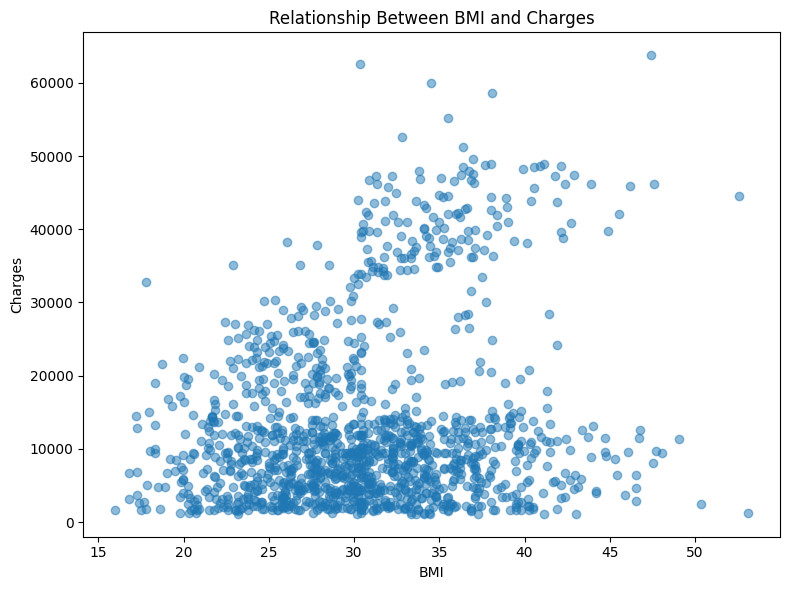

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data['bmi'], data['charges'], alpha=0.5)
plt.title("Relationship Between BMI and Charges")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.tight_layout()
plt.show()

After our investigation ;p we noticed that some charges outliers are connected to a bmi outliers,and we for that we had made the decesion the keep some outliers because of the great significance to our objective

### Outlier detection (IQR method)

- Uses **IQR (Interquartile Range)** to count outliers per numeric column.
- Outliers fall outside `[Q1−1.5×IQR, Q3+1.5×IQR]`.

In [ ]:
Q1_bmi = data['bmi'].quantile(0.25)
Q3_bmi = data['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi
lower_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bmi = Q3_bmi + 1.5 * IQR_bmi

# 2) Identify charges outliers (above 99th percentile)
charge_99th_percentile = data['charges'].quantile(0.99)
charge_outliers = data['charges'] > charge_99th_percentile

# 3) Keep charges outliers only if the BMI is also an outlier
bmi_outliers = (data['bmi'] < lower_bmi) | (data['bmi'] > upper_bmi)

# 4) Remove charges outliers if the corresponding BMI is not an outlier
data_cleaned = data[~(charge_outliers & ~bmi_outliers)]  # Remove charges outliers that are not BMI outliers

# 5) Verify the result after cleaning
show_table("After Removing Charges Outliers (not related to BMI outliers)", data_cleaned.head())


=== After Removing Charges Outliers (not related to BMI outliers) ===


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


### Label encoding selected columns

- Applies **One‑Hot Encoding** for nominal variables to make them usable by models.
- Drops the first dummy to avoid the **dummy variable trap**.
- Uses **LabelEncoder** (ordinal IDs) for specific columns where integer labels are acceptable.

In [ ]:
data_encoded = pd.get_dummies(data_cleaned, columns=['sex', 'smoker'], drop_first=True)

# Convert all boolean dummies to int (0/1)
for col in ['sex_male', 'smoker_yes']:
    data_encoded[col] = data_encoded[col].astype(int)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data_encoded['region'] = label_encoder.fit_transform(data_encoded['region'])

print(data_encoded.head())

    age     bmi  children  region      charges  sex_male  smoker_yes
0  19.0  27.900       0.0       3  16884.92400         0           1
1  18.0  33.770       1.0       2   1725.55230         1           0
2  28.0  33.000       3.0       2   4449.46200         1           0
3  33.0  22.705       0.0       1  21984.47061         1           0
4  32.0  28.880       0.0       1   3866.85520         1           0


In [ ]:
show_table("After One-Hot and Label Encoding", data_encoded.head())


=== After One-Hot and Label Encoding ===


,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,0,1
1,18.0,33.770,1.0,2,1725.55230,1,0
2,28.0,33.000,3.0,2,4449.46200,1,0
3,33.0,22.705,0.0,1,21984.47061,1,0
4,32.0,28.880,0.0,1,3866.85520,1,0


In [ ]:
data_encoded.dtypes

,0
age,float64
bmi,float64
children,float64
region,int64
charges,float64
sex_male,int64
smoker_yes,int64


#Feature engineering

### PCA (dimensionality reduction)

- Runs **Principal Component Analysis** on scaled data.
- Reports **explained variance ratio** per component to judge compression quality.


In [ ]:
# ===================== PCA FOR ALL FEATURES =====================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)  # Apply on all the encoded features
pca = PCA(n_components=len(data_encoded.columns))  # Keep all components to explain each feature's weight
pca.fit(data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
feature_weights = pd.DataFrame(pca.components_, columns=data_encoded.columns)
print("\nExplained Variance Ratio (Contribution of each component):")
print(explained_variance_ratio)
show_table("Feature Weights for All Principal Components", feature_weights)
first_pc_weights = feature_weights.iloc[0].abs().sort_values(ascending=False)
print("\nFeatures with the most influence on the first principal component:")
print(first_pc_weights)



Explained Variance Ratio (Contribution of each component):
[0.26043205 0.16981696 0.15048426 0.14238015 0.13771196 0.11544167
 0.02373295]

=== Feature Weights for All Principal Components ===


,age,bmi,children,region,charges,sex_male,smoker_yes
0,0.231103,0.174365,0.074313,0.011522,0.706421,0.094119,0.634543
1,0.374489,0.641426,0.196142,0.562044,-0.034327,-0.030586,-0.303071
2,0.636524,-0.195974,0.265745,-0.421747,0.061437,-0.516560,-0.193215
3,-0.010378,-0.096446,0.776459,-0.171880,-0.052306,0.589823,-0.086784
4,0.422374,0.179814,-0.517940,-0.385481,-0.015234,0.574978,-0.203908
5,-0.394792,0.678088,0.111421,-0.571551,0.005355,-0.211734,-0.019771
6,-0.258493,-0.135373,-0.042673,0.035978,0.702154,0.007040,-0.647047



Features with the most influence on the first principal component:
charges       0.706421
smoker_yes    0.634543
age           0.231103
bmi           0.174365
sex_male      0.094119
children      0.074313
region        0.011522
Name: 0, dtype: float64


In [ ]:
# 1. Save non-encoded cleaned dataset
data_cleaned.to_csv("data_cleaned.csv", index=False)

# 2. Save encoded cleaned dataset
data_encoded.to_csv("data_encoded.csv", index=False)

# 3. Download both
from google.colab import files
files.download("data_cleaned.csv")
files.download("data_encoded.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_encoded

,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,0,1
1,18.0,33.770,1.0,2,1725.55230,1,0
2,28.0,33.000,3.0,2,4449.46200,1,0
3,33.0,22.705,0.0,1,21984.47061,1,0
4,32.0,28.880,0.0,1,3866.85520,1,0
...,...,...,...,...,...,...,...
1333,50.0,30.970,3.0,1,10600.54830,1,0
1334,18.0,31.920,0.0,0,2205.98080,0,0
1335,18.0,36.850,0.0,2,1629.83350,0,0
1336,21.0,25.800,0.0,3,2007.94500,0,0


In [ ]:
data_cleaned

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,21.0,female,25.800,0.0,no,southwest,2007.94500


# 4/ *Modeling*   

DSO1 : On utilise la régression car le problème est prédictif et quantitatif : on veut estimer des montants financiers (charges médicales) .//"J'ai choisi Random Forest pour sa capacité unique à modéliser les relations non-linéaires entre les variables médicales et démographiques, tout en garantissant la robustesse nécessaire à des prédictions financières précises et généralisables."



DSO 2


🔹 Isolation Forest

Principe : construit des arbres de partition aléatoires → les points rares s’isolent plus vite.

Avantage : efficace sur des données tabulaires, robuste aux grands volumes.

🔹 One-Class SVM

Principe : trouve une frontière qui entoure la majorité des données → les points hors de cette frontière sont des anomalies.

Avantage : efficace mais sensible au choix du kernel et au volume de données.

Pipeline modèle :

Diviser le dataset en X (features).

Standardiser les données.

Appliquer Isolation Forest et One-Class SVM.

Comparer les anomalies détectées.

# 5/ *Evaluation*

pour chaque DSO , evaluer chaque methode modelise la phase precedente.

# 6/ *Deployement*

1.   Élément de liste
2.   Élément de liste



pour chaque BO  , presente la solution final au decideur

In [ ]:
!git clone https://github.com/yosriawedi/ML-Project-Insurance/blob/main/NeuroNova.ipynb


/content/ML-Project-Insurance


In [149]:
!git commit --allow-empty -m "Force commit: resave NeuroNova notebook"
!git push origin main


[main 10a5720] Force commit: resave NeuroNova notebook
Enumerating objects: 1, done.
Counting objects: 100% (1/1), done.
Writing objects: 100% (1/1), 205 bytes | 102.00 KiB/s, done.
Total 1 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/yosriawedi/ML-Project-Insurance.git
   bf486c4..10a5720  main -> main


In [145]:


# 3. Ajouter et forcer l'ajout
!git add -f NeuroNova.ipynb

# 4. Commit
!git commit -m "Update NeuroNova notebook from Colab root copy"

# 5. Push
!git push origin main



On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [ ]:
!git clone https://github.com/yosriawedi/ML-Project-Insurance.git

Cloning into 'ML-Project-Insurance'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 51 (delta 16), reused 18 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 3.09 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
!git branch



fatal: not a git repository (or any of the parent directories): .git
